Using pre-trained LSTM model for shear stress prediction of the p5271 experiment

In [ ]:
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential
from keras.optimizers import RMSprop, Adam
from keras.layers import Dense, LSTM, TimeDistributed, Flatten, Bidirectional, Dropout
from keras.layers.convolutional import Conv1D, MaxPooling1D
from sklearn.preprocessing import MinMaxScaler
from keras.utils import plot_model
from keras.models import load_model
import time
import h5py
import tensorflow as tf


In [ ]:
# Function to create data with timesteps

def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)):
		end_ix = i + n_steps
		if end_ix > len(data):
			break
		x1, y1 = data[i:end_ix, :-1], data[end_ix-1, -1]  #last column is the target variable
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)
 

In [ ]:
# Load the data

data = loadmat('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/data/p5271_ML_Master.mat')
m_t = pd.DataFrame({'Time':data['Time'].ravel().round(2), 'SS':data['SS'].ravel()})
a_t = pd.DataFrame({'Time':data['LocalAcTime'].ravel().round(2), 'V_filt':data['V_filt'].ravel(), 'Vel_pc':data['Vel_pc'].ravel(),
                    'A_filt':data['A_filt'].ravel(), 'T_pc':data['T_pc'].ravel()})  
df1 = a_t.merge(m_t, on='Time')

df = df1.drop(['Time'], axis=1)   # Drop irrelevant features
print("Input data:\n", df)


Input data:
             V_filt  Vel_pc       A_filt  T_pc        SS
0      5713.739611     0.0  5023.620000   0.0  5.893849
1      5713.748279     0.0  5022.966667   0.0  5.893360
2      5713.750421     0.0  5023.171429   0.0  5.893242
3      5713.758606     0.0  5025.250000   0.0  5.893039
4      5713.772870     0.0  5026.288889   0.0  5.892528
...            ...     ...          ...   ...       ...
75994  5720.364457     0.0  4885.680000   0.0  5.850977
75995  5720.365210     0.0  4885.477778   0.0  5.851531
75996  5720.384980     0.0  4886.137500   0.0  5.852108
75997  5720.393775     0.0  4885.842857   0.0  5.852526
75998  5720.397332     0.0  4885.700000   0.0  5.852725

[75999 rows x 5 columns]


In [ ]:
# Preprocessing

arr = df.to_numpy()
n_steps = 60
xdf, ydf = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape, Y = ', np.shape(ydf))


Features shape, X =  (75940, 60, 4)
Target shape, Y =  (75940,)


In [ ]:
# Split into train-val-test
x_train, x_test, y_train, y_test = train_test_split(xdf, ydf, test_size=0.4, shuffle=False)
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.1, shuffle=False)

# Normalize the features
scaler = MinMaxScaler()
num_instances, num_time_steps, num_features = X_train.shape
X_train = scaler.fit_transform(np.reshape(X_train, (-1, num_features)))
X_train = np.reshape(X_train, (num_instances, num_time_steps, num_features))

num_instances, num_time_steps, num_features = X_val.shape
X_val = scaler.transform(np.reshape(X_val, (-1, num_features)))
X_val = np.reshape(X_val, (num_instances, num_time_steps, num_features))

num_instances, num_time_steps, num_features = x_test.shape
x_test = scaler.transform(np.reshape(x_test, (-1, num_features)))
x_test = np.reshape(x_test, (num_instances, num_time_steps, num_features))

print("Training:", np.shape(X_train))
print("Validation:", np.shape(X_val))
print("Testing:", np.shape(x_test))


Training: (41007, 60, 4)
Validation: (4557, 60, 4)
Testing: (30376, 60, 4)


Epoch 1/5
1282/1282 [==============================] - 127s 99ms/step - loss: 8.0814e-04 - val_loss: 0.0011
Epoch 2/5
1282/1282 [==============================] - 128s 100ms/step - loss: 5.7939e-04 - val_loss: 7.7339e-04
Epoch 3/5
1282/1282 [==============================] - 130s 101ms/step - loss: 5.1870e-04 - val_loss: 8.1975e-04
Epoch 4/5
1282/1282 [==============================] - 129s 100ms/step - loss: 5.1171e-04 - val_loss: 6.8436e-04
Epoch 5/5
1282/1282 [==============================] - 129s 101ms/step - loss: 4.7730e-04 - val_loss: 0.0011


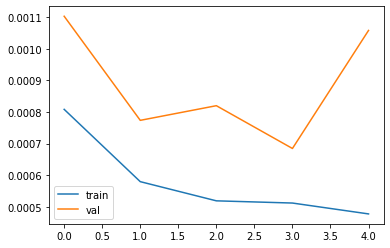

---Training time: 643.88817334 seconds ---


In [ ]:
# Load the pretrained model and re-fit

model = load_model('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/models/LSTM_t1_ss.h5')

model.compile(loss='mse', optimizer='adam')

start_time = time.time()
history = model.fit(X_train, Y_train, epochs=5, batch_size=32, validation_data=(X_val, Y_val), verbose=1)
end_time = time.time()

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

print("---Training time: %0.8f seconds ---" % (end_time - start_time))


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               68096     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 76,417
Trainable params: 76,417
Non-trainable params: 0
_________________________________________________________________
None


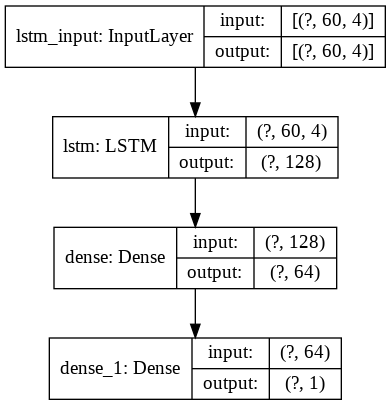

In [ ]:
print(model.summary())
plot_model(model, show_shapes=True)

In [ ]:
# Evaluate the model

y_predTrain = model.predict(X_train)
train_r2 = r2_score(Y_train, y_predTrain)
train_rmse = np.sqrt(mean_squared_error(Y_train, y_predTrain))

y_predVal = model.predict(X_val)
val_r2 = r2_score(Y_val, y_predVal)
val_rmse = np.sqrt(mean_squared_error(Y_val, y_predVal))  

start_time = time.time()
y_predTest = model.predict(x_test)
end_time = time.time()

test_r2 = r2_score(y_test, y_predTest)
test_rmse = np.sqrt(mean_squared_error(y_test, y_predTest))

print("R2 scores: Train - %0.5f, Validation - %0.5f, Test - %0.5f" %(train_r2, val_r2, test_r2))
print("RMSE scores: Train - %0.5f, Validation - %0.5f, Test - %0.5f" %(train_rmse, val_rmse, test_rmse))

print("\n---Time for Test data prediction: %0.8f seconds ---" % (end_time - start_time))

R2 scores: Train - 0.94913, Validation - 0.89725, Test - 0.86866
RMSE scores: Train - 0.01789, Validation - 0.03253, Test - 0.04241

---Time for Test data prediction: 8.02880788 seconds ---


In [ ]:
# Save prediction
'''
hf = h5py.File('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/predictions/transfer_lstm_ss1.h5', 'w')
hf.create_dataset('y_predTrain', data=y_predTrain)
hf.create_dataset('y_predVal', data=y_predVal)
hf.create_dataset('y_predTest', data=y_predTest)
hf.close()
'''